In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from scipy.interpolate import griddata
from matplotlib.path import Path
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial import cKDTree
from scipy.ndimage import gaussian_filter
import random

In [3]:
coords = np.asarray([(22,4),(22,2),(22,0),(21,3),(21,1),(20,4),(20,2),(20,0),
                    (16.5,3),(16.5,1),(15.5,4),(15.5,2),(15.5,0),(14.5,3),(14.5,1),(13.5,4),(13.5,2),(13.5,0),
                    (8.5,4),(8.5,2),(8.5,0),(7.5,3),(7.5,1),(6.5,4),(6.5,2),(6.5,0),(5.5,3),(5.5,1),
                    (2,4),(2,2),(2,0),(1,3),(1,1),(0,4),(0,2),(0,0),
                    (17.5,19),(17.5,17),(16.5,20),(16.5,18),(16.5,16),(15.5,19),(15.5,17),(14.5,20),(14.5,18),(14.5,16),(13.5,19),(13.5,17),
                    (5.5,19),(4,20.5),(4,19),(4,17.5),(2.5,22),(2.5,20.5),(2.5,19),(1,20.5),
                    (-5,20),(-5,18),(-5,16),(-6,19),(-6,17),(-7,20),(-7,18),(-7,16)])         # shape (64, 2)
values = np.array([round(random.uniform(0, 1), 1) for _ in range(64)])         # shape (64,)
print(values)

[0.2 1.  0.8 0.8 0.4 0.2 0.2 1.  0.8 0.7 0.2 0.7 0.3 0.9 1.  0.4 0.9 0.2
 0.9 0.5 0.3 0.8 0.3 1.  0.5 0.9 0.3 0.6 0.8 0.6 0.5 0.6 0.7 0.4 1.  0.1
 0.6 0.2 0.4 0.2 0.6 0.8 0.3 0.6 0.6 0.9 0.2 0.4 0.5 0.1 0.  0.  0.8 0.9
 0.1 0.7 0.9 1.  0.2 0.5 0.3 0.9 0.7 0.5]


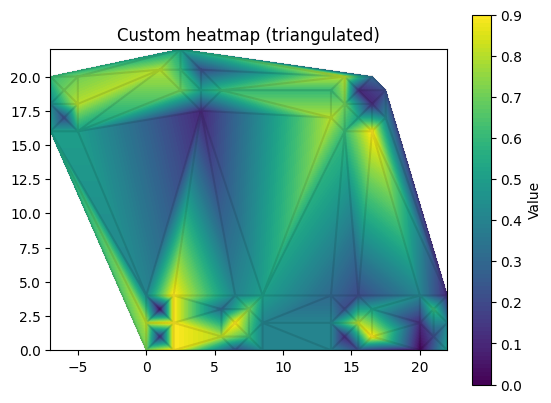

In [17]:
tri = mtri.Triangulation(coords[:,0], coords[:,1])
plt.figure()
cntr = plt.tricontourf(tri, values, levels=100, cmap='viridis')  # dense levels for smooth look
plt.triplot(tri, color='k', alpha=0.1)                           # optional: show triangulation
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar(cntr, label='Value')
plt.title('Custom heatmap (triangulated)')
plt.show()

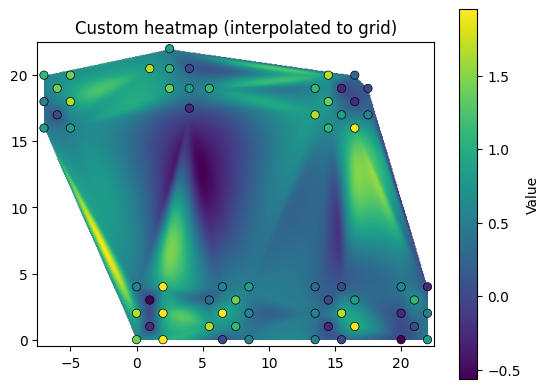

In [25]:
xy=coords
z=values

xmin, ymin = xy.min(axis=0)
xmax, ymax = xy.max(axis=0)
nx, ny = 400, 400                 # resolution of the output heatmap
gx, gy = np.meshgrid(np.linspace(xmin, xmax, nx),
                     np.linspace(ymin, ymax, ny))

# interpolate (choose 'linear', 'cubic', or 'nearest')
gz = griddata(xy, z, (gx, gy), method='cubic')

# from scipy.ndimage import gaussian_filter
# gz_smooth = gaussian_filter(np.nan_to_num(gz, nan=np.nanmean(z)), sigma=1.5)

# (optional) mask outside the device’s shape if you have its outline as a polygon
# device_outline: (M,2) array of polygon vertices in same coords as xy
# If you have multiple detached parts, build multiple Paths and combine masks.
# Example with a single polygon:
# device_path = Path(device_outline)
# mask = ~device_path.contains_points(np.c_[gx.ravel(), gy.ravel()]).reshape(gx.shape)
# gz = np.ma.array(gz, mask=mask)

plt.figure()
im = plt.imshow(gz, origin='lower', extent=[xmin, xmax, ymin, ymax], cmap='viridis', aspect='equal')
plt.scatter(xy[:,0], xy[:,1], c=z, edgecolor='k', linewidth=0.5, cmap='viridis')  # show sensors
plt.colorbar(im, label='Value')
plt.xlim(-7.5,22.5)
plt.ylim(-0.5, 22.5)
plt.title('Custom heatmap (interpolated to grid)')
plt.show()

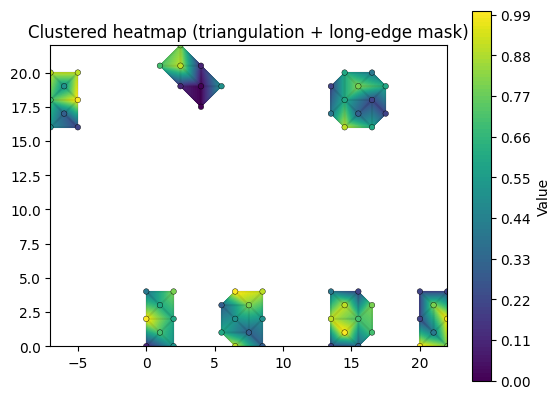

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri

xy = np.asarray(coords, float)
z  = np.asarray(values, float)

tri = mtri.Triangulation(xy[:,0], xy[:,1])

# ----- tunable edge-length cutoff -----
L_max = 3.0   # any triangle with an edge longer than this is masked out
# -------------------------------------

# Compute triangle masks by edge length
x, y = xy[:,0], xy[:,1]
triangles = tri.triangles
p0, p1, p2 = triangles[:,0], triangles[:,1], triangles[:,2]
e01 = np.hypot(x[p0]-x[p1], y[p0]-y[p1])
e12 = np.hypot(x[p1]-x[p2], y[p1]-y[p2])
e20 = np.hypot(x[p2]-x[p0], y[p2]-y[p0])
longest = np.maximum.reduce([e01, e12, e20])
mask = longest > L_max
tri.set_mask(mask)

plt.figure()
cntr = plt.tricontourf(tri, z, levels=100, cmap='viridis')
plt.triplot(tri, color='k', alpha=0.08)      # optional mesh overlay
plt.scatter(x, y, c=z, cmap='viridis', edgecolor='k', s=16, linewidth=0.3)
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar(cntr, label='Value')
plt.title('Clustered heatmap (triangulation + long-edge mask)')
plt.show()


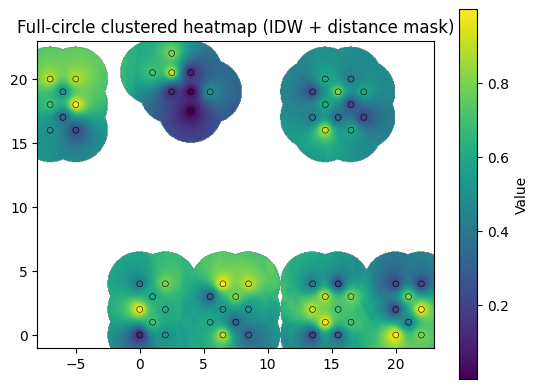

In [13]:
# inputs
xy = np.asarray(coords, float)       # (N, 2)
z  = np.asarray(values, float)       # (N,)

# ----- tunables -----
nx, ny       = 500, 500              # grid resolution
radius       = 2.5                   # influence radius for masking (device units)
k_neighbors  = 8                     # IDW: number of nearest points to blend
power        = 2.0                   # IDW power; higher = less smoothing
smooth_sigma = 0.8                   # optional post-blur of the raster (0 disables)
# ---------------------

# grid covering all sensors (expand a tad so circles are complete at edges)
pad = radius
xmin, ymin = xy.min(axis=0) - pad
xmax, ymax = xy.max(axis=0) + pad
gx, gy = np.meshgrid(np.linspace(xmin, xmax, nx),
                     np.linspace(ymin, ymax, ny))
grid_pts = np.c_[gx.ravel(), gy.ravel()]

# build k-d tree for neighbors and distance mask
tree = cKDTree(xy)

# IDW interpolation (extrapolates everywhere)
dists, idxs = tree.query(grid_pts, k=min(k_neighbors, len(xy)))
# Handle case k=1 -> shape (M,) to (M,1)
if dists.ndim == 1:
    dists = dists[:, None]
    idxs  = idxs[:, None]

# weights: 1 / d^p (avoid div by zero by snapping to exact value when d=0)
eps = 1e-12
w = 1.0 / np.maximum(dists, eps)**power
# if any exact hits, make them take full weight
exact = dists < 1e-12
if np.any(exact):
    w[exact] = 1.0
    # zero out other weights in those rows
    row_has_exact = exact.any(axis=1)
    w[row_has_exact] = exact[row_has_exact].astype(float)

vals_neighbors = z[idxs]                      # (M, k)
gz_flat = (w * vals_neighbors).sum(axis=1) / w.sum(axis=1)

# reshape to grid
gz = gz_flat.reshape(gx.shape)

# distance mask: keep only pixels within 'radius' of the nearest sensor
dmin, _ = tree.query(grid_pts, k=1)
mask_far = dmin.reshape(gx.shape) > radius
gz = np.ma.array(gz, mask=mask_far)

# optional smoothing INSIDE the mask
if smooth_sigma > 0:
    filled = np.where(gz.mask, np.nan, gz.filled(np.nan))
    # fill NaNs with local mean proxy before blur
    fill_val = np.nanmean(z)
    filled = np.where(np.isnan(filled), fill_val, filled)
    filled = gaussian_filter(filled, sigma=smooth_sigma)
    gz = np.ma.array(filled, mask=mask_far)

# plot
plt.figure()
plt.xlim(-8,23)
plt.ylim(-1, 23)
im = plt.imshow(gz, origin='lower',
                extent=[xmin, xmax, ymin, ymax],
                cmap='viridis', aspect='equal')
plt.scatter(xy[:,0], xy[:,1], c=z, cmap='viridis',
            edgecolor='k', linewidth=0.4, s=18)
plt.colorbar(im, label='Value')
plt.title('Full-circle clustered heatmap (IDW + distance mask)')
plt.show()
